In [37]:
!pip install -q xarray zarr 
import xarray as xr
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
ds = xr.open_dataset('data.nc')
ds

<xarray.Dataset>
Dimensions:      (sample: 500, variant: 5000)
Dimensions without coordinates: sample, variant
Data variables:
    data         (variant, sample) int8 ...
    variant_id   (variant) object ...
    contig       (variant) int32 ...
    pos          (variant) int32 ...
    sample_id    (sample) object ...
    covariate_0  (sample) float64 ...
    phenotype_0  (sample) float64 ...

In [3]:
df = pd.read_csv('results.csv')
df.head()

,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,4052,snp495_m0_.01m1_.04,5,4052,4052,7.108119e-24,-0.430418,0.040536,0.430004,0.0,0.0
1,2392,snp1422_m0_.49m1_.5,3,2392,2392,1.285284e-21,0.409757,0.040927,0.409676,0.0,0.0
2,2650,snp1200_m0_.37m1_.36,3,2650,2650,1.501531e-13,-0.322766,0.042478,0.322615,0.0,0.0
3,2003,snp433_m0_.14m1_.11,3,2003,2003,8.084090e-10,0.271265,0.043298,0.270544,0.0,0.0
4,180,snp2504_m0_.49m1_.15,1,180,180,5.708216e-05,0.179342,0.044177,0.179154,0.0,0.0


In [4]:
np.argwhere(ds.variant_id.values == 'snp495_m0_.01m1_.04')

array([[4052]])

In [5]:
df.pipe(lambda df: df[df['Chr'] == 5]).pipe(lambda df: df[df['ChrPos'] == 4052])

,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,4052,snp495_m0_.01m1_.04,5,4052,4052,7.108119e-24,-0.430418,0.040536,0.430004,0.0,0.0


In [6]:
df.pipe(lambda df: df[df['Chr'] == 3]).pipe(lambda df: df[df['ChrPos'] == 2392])

,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
1,2392,snp1422_m0_.49m1_.5,3,2392,2392,1.285284e-21,0.409757,0.040927,0.409676,0.0,0.0


In [7]:
np.argwhere(ds.variant_id.values == 'snp1422_m0_.49m1_.5')

array([[2392]])

In [8]:
df.pipe(lambda df: df[df['Chr'] == 1]).pipe(lambda df: df[df['ChrPos'] == 180])

,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
4,180,snp2504_m0_.49m1_.15,1,180,180,0.000057,0.179342,0.044177,0.179154,0.0,0.0


In [9]:
np.argwhere(ds.variant_id.values == 'snp2504_m0_.49m1_.15')

array([[180]])

In [10]:
Xf = ds.data.values.T

Xf = (Xf - Xf.mean(axis=0, keepdims=True)) / (Xf.std(axis=0, keepdims=True))

u, s, v = np.linalg.svd(Xf)
Xf.shape, u.shape, s.shape, v.shape

((500, 5000), (500, 500), (500,), (5000, 5000))

In [11]:
s.min(), s.max()

(2.4859660134681223e-13, 379.24053399391164)

In [12]:
#X = ds.data.values[[4052]]
#X = Xf.T[[4052]]
#X = Xf.T[[2392]]
X = Xf.T[[180]]

cov = ds.covariate_0.values[np.newaxis]
X = np.concatenate((
    X, 
    cov,
    np.ones((1,X.shape[1]))
), axis=0)
X.shape

(3, 500)

In [105]:
from fastlmm.inference import lmm_cov 
lmm = lmm_cov.LMM()

# where eigendecomp is done in fastlmm:
# https://github.com/fastlmm/FaST-LMM/blob/ff183d3aa09c78cf5fdf1961e9241e8a9b9dd172/fastlmm/inference/lmm_cov.py#L84
# https://github.com/fastlmm/FaST-LMM/blob/master/fastlmm/association/single_snp.py#L550
Xcov = np.concatenate((
    ds.covariate_0.values[np.newaxis],
    np.ones((1, 500))
), axis=0)
lmm = lmm_cov.LMM(
    forcefullrank=True,
    X=Xcov.T, 
    Y=ds.phenotype_0.values.reshape(-1, 1), 
    #K=ds.data.values.T.astype('float32') @ ds.data.values.astype('float32'), 
    K=Xf @ Xf.T,
    G=None, 
    inplace=False
)

In [106]:
s_lmm, u_lmm = lmm.getSU()
s_lmm.shape, u_lmm.shape

((498,), (500, 498))

In [107]:
s_lmm.min(), s_lmm.max()

(2241.6867958327034, 143742.05458977356)

In [108]:
lmm.rotate(Xf)[0].shape

(498, 5000)

In [109]:
lmm.getUY()[0].shape

(498, 1)

In [110]:
lmm.rotate(Xf)[0][:, [23]].shape

(498, 1)

In [111]:
(s[:,np.newaxis]**2).min(), (s[:,np.newaxis]**2).max()

(6.180027020118588e-26, 143823.38262398724)

In [135]:
def run(ds, idx, lmm):
    Xf = ds.data.values.T
    ni, nv = Xf.shape
    Xf = (Xf - Xf.mean(axis=0, keepdims=True)) / (Xf.std(axis=0, keepdims=True))
    
    s, _ = lmm.getSU()
    Xfr = lmm.rotate(Xf)[0]
    Yr = lmm.getUY()[0][:, 0]
    
    res = []
    for i in idx:
        Xm = Xfr[:, [i]]
        m = sm.WLS(Yr, Xm, weights=1./np.sqrt(s), hasconst=False).fit()
        sid = ds.variant_id.values[i]
        res.append((i, sid, m))
    return pd.DataFrame(res, columns=['i', 'sid', 'm'])

In [142]:
dfm = run(ds, np.arange(5000), lmm)
dfc = pd.merge(df[['SNP', 'SnpWeight', 'PValue']], dfm.rename(columns={'sid': 'SNP'}), on='SNP', how='inner')
dfc['beta'] = dfc['m'].apply(lambda x: x.params[0])
dfc['p'] = dfc['m'].apply(lambda x: x.pvalues[0])
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNP        5000 non-null   object 
 1   SnpWeight  5000 non-null   float64
 2   PValue     5000 non-null   float64
 3   i          5000 non-null   int64  
 4   m          5000 non-null   object 
 5   beta       5000 non-null   float64
 6   p          5000 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 312.5+ KB


In [143]:
(dfc['beta'] - dfc['SnpWeight']).describe()

count    5000.000000
mean       -0.001772
std         0.021996
min        -0.074882
25%        -0.017357
50%        -0.001473
75%         0.013566
max         0.082813
dtype: float64

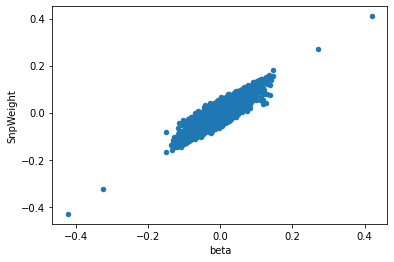

In [144]:
dfc.plot(kind='scatter', x='beta', y='SnpWeight')

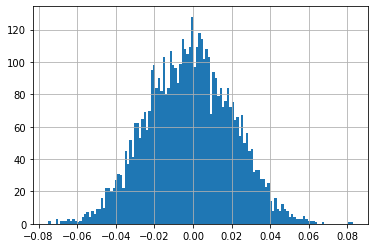

In [145]:
(dfc['beta'] - dfc['SnpWeight']).hist(bins=128)

In [146]:
dfc\
    .assign(p1=lambda df: -df['p'].apply(np.log))\
    .assign(p2=lambda df: -df['PValue'].apply(np.log))\
    .pipe(lambda df: df['p1'] - df['p2'])\
    .describe()

count    5000.000000
mean       -0.230668
std         0.698193
min        -4.126438
25%        -0.622272
50%        -0.152654
75%         0.169319
max         3.156768
dtype: float64

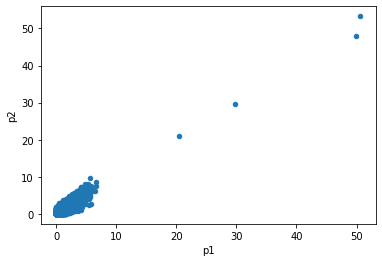

In [147]:
dfc\
    .assign(p1=lambda df: -df['p'].apply(np.log))\
    .assign(p2=lambda df: -df['PValue'].apply(np.log))\
    .plot(kind='scatter', x='p1', y='p2')

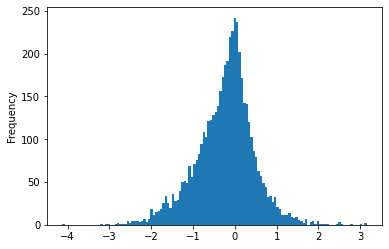

In [148]:
dfc\
    .assign(p1=lambda df: -df['p'].apply(np.log))\
    .assign(p2=lambda df: -df['PValue'].apply(np.log))\
    .pipe(lambda df: df['p1'] - df['p2'])\
    .plot(kind='hist', bins=128)

------

In [149]:
def run(ds, idx):
    Xf = ds.data.values.T
    ni, nv = Xf.shape
    Xf = (Xf - Xf.mean(axis=0, keepdims=True)) / (Xf.std(axis=0, keepdims=True))

    u, s, v = np.linalg.svd(Xf)
    
    cov = ds.covariate_0.values[np.newaxis]
    
    res = []
    for i in idx:
        X = Xf.T[i] 
        X = np.concatenate((
            X[np.newaxis], 
            cov,
            np.ones((1,ni))
        ), axis=0)

        Y = ds.phenotype_0.values

        Xp = u.T @ X.T
        Yp = u.T @ Y
        
        m = sm.WLS(Yp, Xp, weights=1./(s), hasconst=True).fit()
        
        sid = ds.variant_id.values[i]
        res.append((i, sid, m))
    return pd.DataFrame(res, columns=['i', 'sid', 'm'])

In [151]:
dfm = run(ds, np.arange(5000))
dfc = pd.merge(df[['SNP', 'SnpWeight', 'PValue']], dfm.rename(columns={'sid': 'SNP'}), on='SNP', how='inner')
dfc['beta'] = dfc['m'].apply(lambda x: x.params[0])
dfc['p'] = dfc['m'].apply(lambda x: x.pvalues[0])
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNP        5000 non-null   object 
 1   SnpWeight  5000 non-null   float64
 2   PValue     5000 non-null   float64
 3   i          5000 non-null   int64  
 4   m          5000 non-null   object 
 5   beta       5000 non-null   float64
 6   p          5000 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 312.5+ KB


In [152]:
(dfc['beta'] - dfc['SnpWeight']).describe()

count    5000.000000
mean       -0.001772
std         0.021994
min        -0.074857
25%        -0.017352
50%        -0.001479
75%         0.013563
max         0.082815
dtype: float64

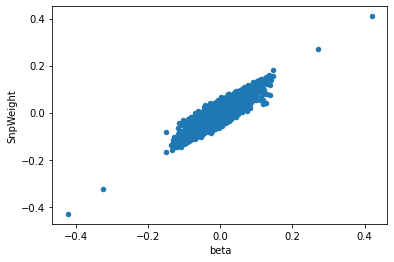

In [153]:
dfc.plot(kind='scatter', x='beta', y='SnpWeight')

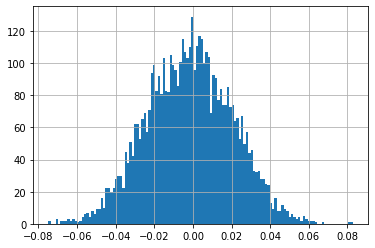

In [154]:
(dfc['beta'] - dfc['SnpWeight']).hist(bins=128)

In [155]:
dfc\
    .assign(p1=lambda df: -df['p'].apply(np.log))\
    .assign(p2=lambda df: -df['PValue'].apply(np.log))\
    .pipe(lambda df: df['p1'] - df['p2'])\
    .describe()

count    5000.000000
mean       -0.230677
std         0.698125
min        -4.125827
25%        -0.622239
50%        -0.152603
75%         0.169677
max         3.155749
dtype: float64

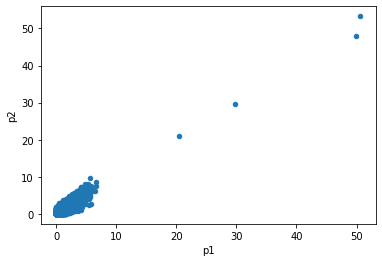

In [156]:
dfc\
    .assign(p1=lambda df: -df['p'].apply(np.log))\
    .assign(p2=lambda df: -df['PValue'].apply(np.log))\
    .plot(kind='scatter', x='p1', y='p2')

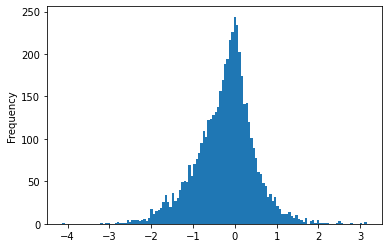

In [157]:
dfc\
    .assign(p1=lambda df: -df['p'].apply(np.log))\
    .assign(p2=lambda df: -df['PValue'].apply(np.log))\
    .pipe(lambda df: df['p1'] - df['p2'])\
    .plot(kind='hist', bins=128)